In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

In [42]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_all = pd.concat([df_train, df_test])

In [43]:
# Add Surnames
surnames = df_all.Name.map(lambda x: str(x).split(",")[0].strip())
df_all = pd.concat([df_all,surnames.rename('Surname')], axis = 1)

In [44]:
# Add Titles
titles = df_all.Name.map(lambda x: str(x).split(".")[0].split(",")[1].strip())
titles = titles.map(lambda x: "Richboys" if (x in ['Dr', 'Rev', 'Col', 'Major', 'Jonkheer', 'Don', 'Sir', 'Capt']) else x)
titles = titles.map(lambda x: "Richgals" if x in ['Mlle', 'the Countess', 'Lady', 'Mme', 'Dona'] else x)
titles = titles.map(lambda x: "Miss" if x in ['Ms'] else x)
df_all = pd.concat([df_all,titles.rename('Title')], axis = 1)

In [45]:
# Add IsMarried

df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

/Users/kdev/Desktop/titanic/venv/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [46]:
# Add Deck 
deck = df_all.Cabin.map(lambda x: str(x)[:1] if str(x) != "nan" else "M")
df_all = pd.concat([df_all, deck.rename('Deck')], axis = 1)
# df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C', 'T'], 'ABC')
# df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
# df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

In [47]:
# Add Family Size
fam_size = df_all.SibSp + df_all.Parch + 1
df_all = pd.concat([df_all, fam_size.rename('Family Size')], axis = 1)

In [48]:
# Add Ticket Frequency
ticket_freq = df_all.Ticket.map(lambda x: df_all.Ticket.value_counts().loc[x])
df_all = pd.concat([df_all, ticket_freq.rename('Ticket_Frequency')], axis = 1)

In [49]:
df_all.Embarked.fillna('C', inplace = True)

In [50]:
# Columns to use
good_cols = ['Pclass', 'Sex', 'Age', 'Embarked', 'Title', 'Family Size', 'Deck', 'Fare', 'Is_Married']
categorical_cols = ['Pclass', 'Sex', 'Title', 'Embarked', 'Deck', 'Is_Married']

In [51]:
# Convert string features to categories

# df_all[categorical_cols] = df_all[categorical_cols].apply(lambda x: x.astype("category"), axis = 0)

for c in categorical_cols:
    df_all[c] = pd.factorize(df_all[c])[0]+1

In [52]:
# Split into training and dev
df = df_all.iloc[:len(df_train)]
df_test = df_all.iloc[len(df_train):]


In [53]:
# Age
def age_filler(local_df):
    median_ages = local_df.groupby(["Title", "Pclass"]).Age.transform("median")
    local_df.Age = local_df.Age.fillna(median_ages)
    return local_df

age_transformer = FunctionTransformer(age_filler)

In [64]:
# Preprocessor

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

interaction_transformer = Pipeline(steps = [
    ('interaction', PolynomialFeatures())
])
preprocessor = ColumnTransformer(
    transformers=[
         ('age_filler', age_transformer, ["Title", "Age", "Pclass"]),
         ('cat', categorical_transformer, categorical_cols),
        ('scaler', numerical_transformer, ['Age', 'Fare', 'Family Size']),
        ('int', interaction_transformer, ['Sex', 'Title', 'Family Size', 'Pclass'])

    ])

In [65]:
X = df[good_cols]
y = df['Survived'].astype('category')

In [66]:
def get_score(n_estimators):
    model = RandomForestClassifier(n_estimators)
    my_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                                ('model', model)
                               ])
    scores = cross_val_score(my_pipeline, X, y, cv = 5, scoring = 'accuracy')
    return scores.mean()

In [67]:
# results = { i: get_score(i, X,y) for i in range(1,400, 50)}
# results = pd.DataFrame([get_score(i) for i in range(1,400, 50)], list(range(1,400, 50)), )

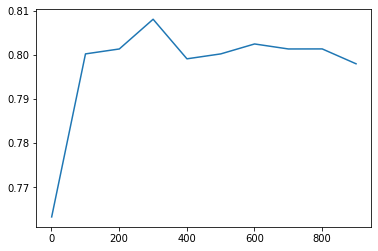

In [68]:
import seaborn as sns

sns.lineplot(x = list(range(1,1000, 100)), y = [get_score(i) for i in list(range(1,1000, 100))])

We can see that 400 is the best. Let's make the actual predictions now. 

In [71]:
model = RandomForestClassifier(300)
my_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                            ('model', model)
                           ])
my_pipeline.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('age_filler',
                                                  FunctionTransformer(func=<function age_filler at 0x114976e18>),
                                                  ['Title', 'Age', 'Pclass']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Title',
                                                   'Embarked', 'Deck',
                                                   'Is_Married']),
                                                 ('scaler',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                            

In [72]:
predictions = my_pipeline.predict(df_test[good_cols])

In [73]:
output = pd.DataFrame({'PassengerId': df_test.PassengerId,
                       'Survived': predictions.astype("int64")})
output.to_csv('submission3.csv', index=False)